In [ ]:
#!pip install --upgrade networkx

In [1]:
import azureml.core
from azureml.core import Dataset, Datastore, Workspace, Run

ws = Workspace.from_config()

moviesdf = ws.datasets['netflix_titles'].to_pandas_dataframe()
moviesdf = moviesdf.dropna(axis=0, subset=['description']).reset_index()
print(moviesdf.shape)
moviesdf.head()

(5924, 14)


,index,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,Column13
0,0,81145628.0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.0,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,None
1,1,80117401.0,Movie,Jandino: Whatever it Takes,None,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,None
2,2,70234439.0,TV Show,Transformers Prime,None,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013.0,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",None
3,3,80058654.0,TV Show,Transformers: Robots in Disguise,None,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016.0,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,None
4,4,80125979.0,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017.0,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,None


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vector = TfidfVectorizer(max_df=0.4,min_df=1,stop_words='english',lowercase=True, use_idf=True, norm=u'l2', smooth_idf=True)
tfidf = vector.fit_transform(moviesdf['description'])

k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)

request_transform = vector.transform(moviesdf['description'])
moviesdf['cluster'] = kmeans.predict(request_transform) 
moviesdf['cluster'].value_counts().head()

91     5633
58        8
178       8
173       6
40        6
Name: cluster, dtype: int64

In [3]:
import moviegraph
graph = moviegraph.generate_graph(moviesdf,tfidf)

 iter 0 -- 0.02605605125427246 seconds --
 iter 1000 -- 3.6057770252227783 seconds --
 iter 2000 -- 7.0448668003082275 seconds --
 iter 3000 -- 10.501907587051392 seconds --
 iter 4000 -- 13.93439507484436 seconds --
 iter 5000 -- 17.38645029067993 seconds --
 finish -- 20.55698823928833 seconds --


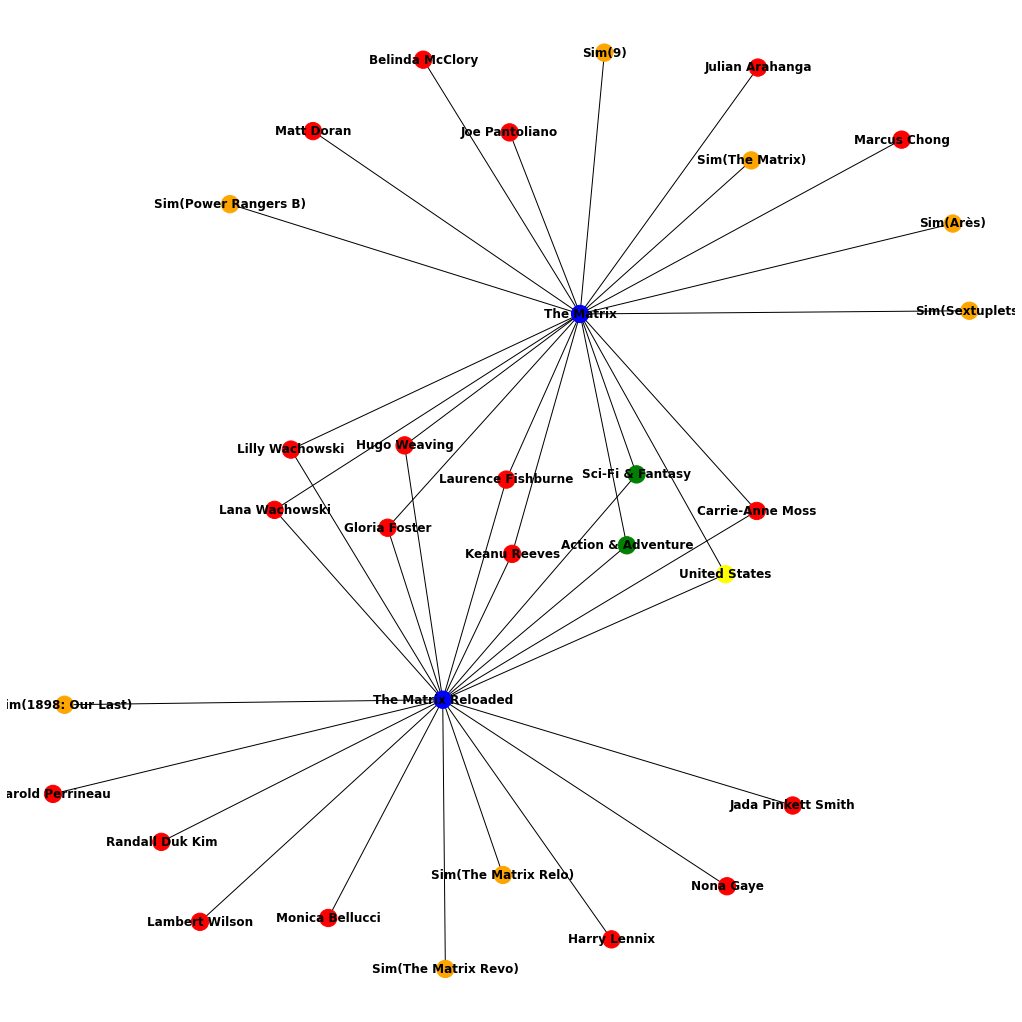

In [4]:
list_in=["The Matrix","The Matrix Reloaded"]
sub_graph = moviegraph.get_all_adj_nodes(list_in, graph)
moviegraph.draw_sub_graph(sub_graph, graph)

In [5]:
moviename = "Sherlock Holmes"
result = moviegraph.get_recommendation(moviename,graph)
print("Recommendation for ",moviename,"\n")
print(result.head())

Recommendation for  Sherlock Holmes 

Oddbods: Party Monsters                2.232443
Agent Raghav                           2.232443
Mark Gatiss: A Study in Sherlock       2.232443
Sherlock                               1.960658
Lock, Stock and Two Smoking Barrels    1.900045
dtype: float64


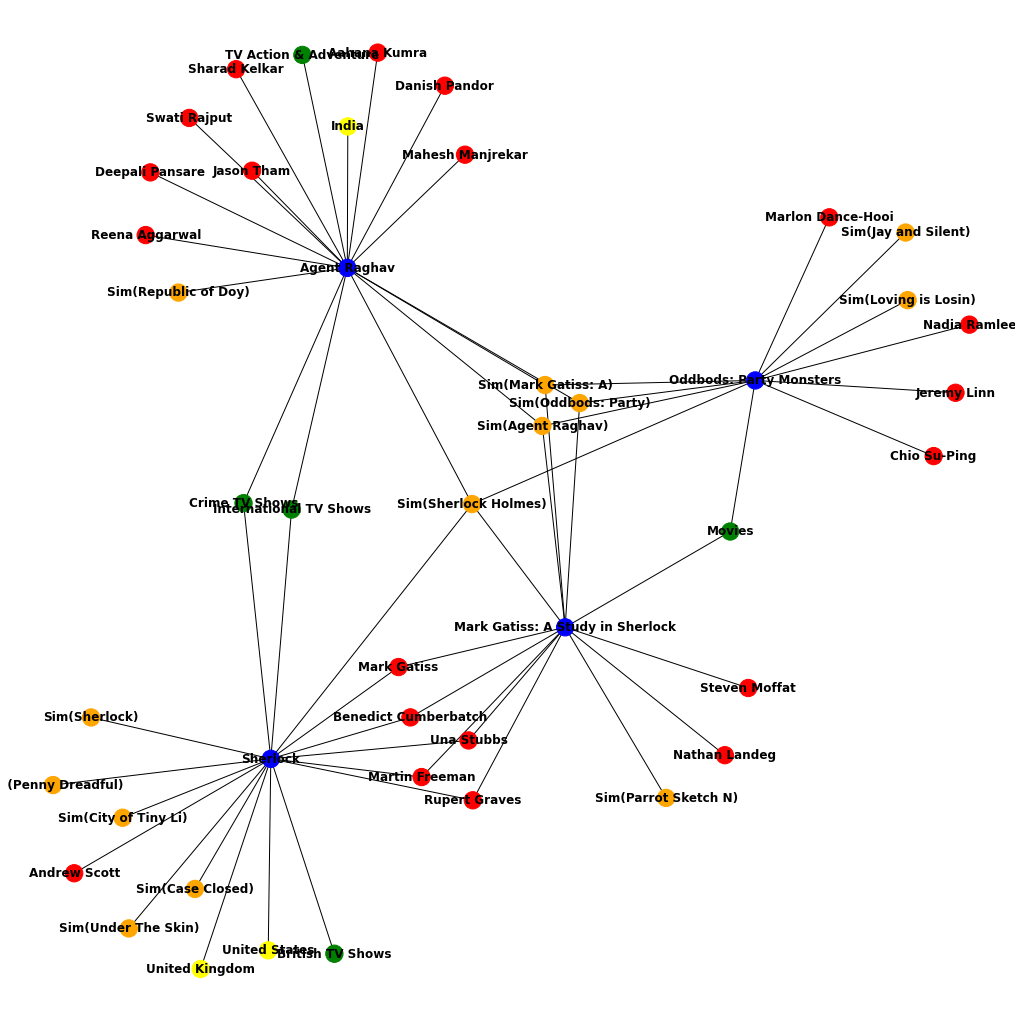

In [6]:
sub_graph = moviegraph.get_all_adj_nodes(list(result.index[:4].values),graph)
moviegraph.draw_sub_graph(sub_graph,graph)